In [1]:
import importlib
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import re
from sklearn.model_selection import train_test_split

# Helper functions

data loader

In [2]:
import numpy as np
from pathlib import Path
import wfdb

def single_file_res(data_folder, file, apn, t_end):
    apn = apn[1:-1]  # Remove first and last APN label

    # ECG data (ecg)
    record = wfdb.rdrecord(str(Path(data_folder) / file))
    ecg = record.p_signal.flatten()
    assert len(ecg) >= t_end * 100, "Period of ecg shorter than label"
    ecg = ecg[:int(t_end * 100)][3000:-3000].reshape(len(apn), 6000)

    # QRS label
    annotation = wfdb.rdann(str(Path(data_folder) / file), extension="qrs")
    qrs = np.array(annotation.symbol)
    t_qrs = annotation.sample / annotation.fs
    mask = t_qrs <= t_end

    if not isinstance(mask, np.ndarray) or mask.dtype != bool:
        raise ValueError(f"Expected mask to be a boolean numpy array, got {type(mask)} with dtype {mask.dtype}")

    qrs = qrs[mask]
    t_qrs = t_qrs[mask]
    idx_qrs = (t_qrs * 100).astype(int)

    # R peak mask (r_peaks) and Artifact mask (atfs)
    r_peaks = np.zeros(int(t_end * 100), dtype=bool)
    atfs = np.zeros(int(t_end * 100), dtype=bool)

    r_mask = (qrs == "N")
    a_mask = (qrs == "|")

    if len(idx_qrs) > 0:
        r_peaks[idx_qrs[r_mask]] = True
        atfs[idx_qrs[a_mask]] = True

    r_peaks = r_peaks[3000:-3000].reshape(len(apn), 6000)
    atfs = atfs[3000:-3000].reshape(len(apn), 6000)

    return apn, ecg, r_peaks, atfs


def get_apn_train(filename):
    annotation = wfdb.rdann(filename, extension="apn")
    apn = annotation.symbol
    t_apn = annotation.sample / annotation.fs

    assert np.all(np.diff(t_apn) == t_apn[1] - t_apn[0]), "Un-uniform label intervals"
    assert t_apn[0] == 0, "APN label does not start from zero"

    apn = np.array([1 if s == 'A' else 0 for s in apn], dtype=bool)

    return apn, t_apn

feature extractor

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plotly.graph_objects as go
from hrvanalysis import get_time_domain_features, get_csi_cvi_features
from scipy import signal
from scipy.signal import convolve
import biosppy


def extract_features(data):
    """Extract features from heart rate data

    Parameters
    ----------
    data: dict with key t and hr
        data['t'] contains a numpy array indicating time in minutes
        data['hr'] contains a numpy array with the same size of data['t']
            indicating heart rate in beats per second

    Returns
    -------
    df: pandas DataFrame
        Features in time and frequency domains for each minute
    """
    fs_new = 2.4  # optimized from hyper-parameter tuning
    thres = 0.015  # optimized from hyper-parameter tuning
    df = pd.DataFrame()

    t_hr, hr = data["t"], data["hr"]
    t_hr, hr_smth = smooth_hr(t_hr, hr)
    total_minute = int(t_hr[-1] - t_hr[0])

    # Resample data for frequency-domain analysis
    t_interp = np.arange(t_hr[0], t_hr[-1], 1 / fs_new / 60)
    hr_interp = np.interp(t_interp, t_hr, hr_smth)

    # Extract features from each segment
    for minute in range(total_minute - 4):
        fea_dict = {}
        idx_1min = (t_hr > minute + 2) & (t_hr < minute + 3)
        idx_5min = (t_hr > minute) & (t_hr < minute + 5)
        data_1min, data_5min = hr_smth[idx_1min], hr_smth[idx_5min]

        hr_interp_1min = hr_interp[(t_interp > minute + 2) & (t_interp < minute + 3)]
        hr_interp_5min = hr_interp[(t_interp > minute) & (t_interp < minute + 5)]

        # Discard segment if less than 30 heart beats detected
        if len(data_1min) < 30:
            continue

        # Time-domain features for data_1min
        md = np.median(data_1min)
        fea_dict.update(
            {
                "md_1min": md,
                "min_r_1min": data_1min.min() - md,
                "max_r_1min": data_1min.max() - md,
                "p25_r_1min": np.percentile(data_1min, 0.25) - md,
                "p75_r_1min": np.percentile(data_1min, 0.75) - md,
                "mean_r_1min": data_1min.mean() - md,
                "std_1min": data_1min.std(),
                "acf1_1min": pd.Series(hr_interp_1min).autocorr(12),
                "acf2_1min": pd.Series(hr_interp_1min).autocorr(24),
            }
        )

        # Time-domain features for data_5min
        md = np.median(data_5min)
        fea_dict.update(
            {
                "md_5min": md,
                "min_r_5min": data_5min.min() - md,
                "max_r_5min": data_5min.max() - md,
                "p25_r_5min": np.percentile(data_5min, 0.25) - md,
                "p75_r_5min": np.percentile(data_5min, 0.75) - md,
                "mean_r_5min": data_5min.mean() - md,
                "std_5min": data_5min.std(),
                "acf1_5min": pd.Series(hr_interp_5min).autocorr(12),
                "acf2_5min": pd.Series(hr_interp_5min).autocorr(24),
            }
        )

        # Heart rate variability for data_1min
        nn_intervals = (np.diff(t_hr[idx_1min]) * 1000 * 60).astype(int)  # Unit in ms
        time_domain_features = get_time_domain_features(nn_intervals)
        time_domain_features = {
            f"{key}_1min": value for key, value in time_domain_features.items()
        }
        nonlinear_features = get_csi_cvi_features(nn_intervals)
        nonlinear_features = {
            f"{key}_1min": value for key, value in nonlinear_features.items()
        }
        fea_dict.update(time_domain_features)
        fea_dict.update(nonlinear_features)

        # Heart rate variability for data_5min
        nn_intervals = (np.diff(t_hr[idx_5min]) * 1000 * 60).astype(int)  # Unit in ms
        time_domain_features = get_time_domain_features(nn_intervals)
        time_domain_features = {
            f"{key}_5min": value for key, value in time_domain_features.items()
        }
        nonlinear_features = get_csi_cvi_features(nn_intervals)
        nonlinear_features = {
            f"{key}_5min": value for key, value in nonlinear_features.items()
        }
        fea_dict.update(time_domain_features)
        fea_dict.update(nonlinear_features)

        # Frequency-domain features
        freqs, psd = signal.periodogram(hr_interp_5min, fs=fs_new)
        psd[freqs > 0.1] = 0
        fea_dict.update(
            {
                "peak": psd.max(),
                "f_peak": freqs[np.argmax(psd)],
                "area_total": psd.sum(),
                "area_lf": psd[freqs < thres].sum(),
                "area_hf": psd[freqs > thres].sum(),
                "area_ratio": psd[freqs > thres].sum() / psd[freqs < thres].sum(),
            }
        )

        df = df.append(fea_dict, ignore_index=True)

    df.dropna(inplace=True)
    return df


# def extract_cwt(
#     file,
#     fs_new=1,
#     smooth=True,
#     cwt_width=100,
#     return_segments=False,
#     segment_window=3,
#     diagPlot=False,
#     xlm=[0, 10],
# ):
#     """Generate Wavelet spectrogram

#     Parameters
#     ----------
#     file: str
#         Name of the pkl file in the data/raw folder
#     fs_new: double
#         Resampling frequency
#     smooth: boolean
#         Whether to smooth data before wavelet transformation
#     cwt_width: int
#         Width parameter for the scipy.signal.cwt function
#     return_segments: boolean
#         Whether to return cwt and apn in segments with window size determined by segment_window
#     segment_window: int
#         Window size in minutes to associate with labels
#         Odd number required
#         Only used when return_segments=True
#     diagPlot: boolean
#         Whether to generate diagnostic plots
#     xlm: list
#         X axis limit for diagnostic plot in minutes, [x_lowerbound, x_upperbound]
#         Only used when diagPlot=True

#     Returns
#     -------
#     cwt: numpy 2D array if return_segments=False, list of numpy 2D array if return_segments=True
#         Wavelet transformation
#     apn: numpy array
#         Apnea label for each minute
#     group: str
#         Severity group of the file (determined directly from file name)
#     """
#     with open("./heartRate/" + file + ".pkl", "rb") as f:
#         data = pickle.load(f)
#         apn = data["apn"]
#         group = file[0].upper()

#     hr_raw, t_raw = data["hr"], data["t"]

#     # Smooth data
#     if smooth:
#         t_raw, hr_raw = smooth_hr(t_raw, hr_raw)

#     # Resample data for frequency-domain analysis
#     t = np.arange(t_raw[0], t_raw[-1], 1 / fs_new / 60)
#     hr = np.interp(t, t_raw, hr_raw)

#     widths = np.arange(1, cwt_width + 1)
#     cwt = signal.cwt(hr, signal.ricker, widths)

#     # Diagnose plot
#     if diagPlot:
#         plt.figure(figsize=(20, 10))
#         # Time history plot
#         # fig.add_subplot(2, 1, 2)
#         plt.subplot(212, position=[0.05, 0.05, 0.9, 0.45])
#         plt.plot(t, hr)
#         plt.xlim(xlm)
#         plt.ylabel("Time series", size=30)
#         plt.xlabel("Minute", size=30)
#         plt.tick_params(labelsize=30)

#         # Wavelet plot
#         plt.subplot(211, position=[0.05, 0.5, 0.9, 0.45])
#         plt.imshow(
#             cwt,
#             cmap="gray",
#             aspect="auto",
#             origin="lower",
#             vmin=-2,
#             vmax=2,
#         )
#         for minute in range(len(apn)):
#             sym = "r-" if apn[minute] else "g-"
#             plt.plot(
#                 np.array([minute, minute + 1]) * 60 * fs_new, [0, 0], sym, linewidth=20
#             )

#         plt.xlim(np.array(xlm) * 60 * fs_new)
#         plt.ylabel("Wavelet", size=30)
#         plt.xticks([])
#         plt.tick_params(labelsize=30)
#         plt.show()

#     if return_segments:
#         half_window = int(segment_window / 2)
#         seg_cwtmatr = []
#         # Skip first and last 2-minute data to eliminate boundary effects of CWT
#         for idx in range(2 + half_window, len(apn) - half_window):
#             minute_start = idx - half_window
#             idx_start = int(minute_start * 60 * fs_new)
#             seg_cwtmatr.append(
#                 cwt[:, idx_start : int(idx_start + segment_window * 60 * fs_new)]
#             )

#         cwt = seg_cwtmatr
#         apn = apn[2 + half_window : len(apn) - half_window]

#     return cwt, apn, group

import numpy as np
from scipy import signal
import pickle
from typing import Tuple, List, Union
import matplotlib.pyplot as plt


def extract_cwt(
    file: str,
    fs_new: float = 1,
    smooth: bool = True,
    cwt_width: int = 100,
    return_segments: bool = False,
    segment_window: int = 3,
    diagPlot: bool = False,
    xlm: List[int] = [0, 10],
) -> Tuple[Union[np.ndarray, List[np.ndarray]], np.ndarray, str]:
    """Generate Wavelet spectrogram"""

    # Load data
    with open(f"./heartRate/{file}.pkl", "rb") as f:
        data = pickle.load(f)

    apn = data["apn"]
    group = file[0].upper()
    hr_raw, t_raw = data["hr"], data["t"]

    # Smooth data if required
    if smooth:
        t_raw, hr_raw = smooth_hr(t_raw, hr_raw)

    # Resample data for frequency-domain analysis
    t = np.arange(t_raw[0], t_raw[-1], 1 / (fs_new * 60))
    hr = np.interp(t, t_raw, hr_raw)

    # Compute Continuous Wavelet Transform
    widths = np.arange(1, cwt_width + 1)
    cwt = signal.cwt(hr, signal.ricker, widths)

    if diagPlot:
        plot_diagnostic(t, hr, cwt, apn, fs_new, xlm)

    if return_segments:
        cwt, apn = segment_data(cwt, apn, fs_new, segment_window)

    return cwt, apn, group


def plot_diagnostic(
    t: np.ndarray,
    hr: np.ndarray,
    cwt: np.ndarray,
    apn: np.ndarray,
    fs_new: float,
    xlm: List[int],
):
    """Generate diagnostic plots"""
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(20, 10), gridspec_kw={"height_ratios": [1, 1]}
    )

    # Wavelet plot
    im = ax1.imshow(cwt, cmap="gray", aspect="auto", origin="lower", vmin=-2, vmax=2)
    ax1.set_ylabel("Wavelet", size=30)
    ax1.tick_params(labelsize=30)
    ax1.set_xticks([])

    # Plot apnea labels
    for minute, is_apnea in enumerate(apn):
        color = "r" if is_apnea else "g"
        ax1.axvline(x=minute * 60 * fs_new, color=color, linewidth=2)

    # Time history plot
    ax2.plot(t, hr)
    ax2.set_xlim(xlm)
    ax2.set_ylabel("Time series", size=30)
    ax2.set_xlabel("Minute", size=30)
    ax2.tick_params(labelsize=30)

    plt.tight_layout()
    plt.show()


def segment_data(
    cwt: np.ndarray, apn: np.ndarray, fs_new: float, segment_window: int
) -> Tuple[List[np.ndarray], np.ndarray]:
    """Segment the CWT data"""
    half_window = segment_window // 2
    seg_cwtmatr = []

    # Skip first and last 2-minute data to eliminate boundary effects of CWT
    for idx in range(2 + half_window, len(apn) - half_window):
        minute_start = idx - half_window
        idx_start = int(minute_start * 60 * fs_new)
        seg_cwtmatr.append(
            cwt[:, idx_start : int(idx_start + segment_window * 60 * fs_new)]
        )

    return seg_cwtmatr, apn[2 + half_window : -half_window]


def smooth_hr(t_hr, hr):
    """Remove outliers and smooth heart rate data

    Parameters
    ----------
    t_hr: numpy array
        Time of heart rate data in minutes, same size as hr
    hr: numpy array
        Heart rate data in beats per second

    Returns
    -------
    t_hr: numpy array
        A subset of the input t_hr with outliers removed
    hr_smth: numpy array
        Smoothed heart rate with the same size of t_hr
    """
    b, a = signal.butter(3, 0.1)

    # Remove outliers
    idx_valid = (hr < 2) & (hr > 0.5)
    hr, t_hr = hr[idx_valid], t_hr[idx_valid]

    # Filter out high-frequency noise
    hr_smth = signal.filtfilt(b, a, hr)

    # Remove outliers again
    idx_valid = (hr < hr_smth + 0.2) & (hr > hr_smth - 0.2)
    hr, t_hr = hr[idx_valid], t_hr[idx_valid]

    # Filter out high-frequency noise
    hr_smth = signal.filtfilt(b, a, hr)

    return t_hr, hr_smth


# def extract_heart_rate(ecg, fs=100):
#     """Calculate heart rate

#     Parameters
#     ----------
#     ecg: numpy 2D array
#     fs: scalar, sampling frequency

#     Returns
#     -------
#     t: numpy array
#         Time of heart rate
#     hr: numpy array
#         Heart rate in beats per second, with the same size as t
#     """
#     window_size = 200
#     weights = np.ones(window_size) / window_size
#     ecg_trend = np.convolve(ecg, weights, mode="same")
#     ecg_detrend = ecg - ecg_trend
#     r_idx = extract_r(ecg_detrend, fs)
#     t = r_idx[1:] / fs
#     hr = 1 / (np.diff(r_idx) / fs)
#     return t, hr


# def extract_r(ecg_detrend, fs=100):
#     """Extract R peaks from ECG data
#     ECG data should have the length around 1 minute to get a stable result

#     Parameters
#     ----------
#     ecg_detrend: numpy array or list
#         Detrended ECG data
#     fs: scalar
#         Sampling frequency of ecg_detrend

#     Returns
#     -------
#     r_idx: Index of R peaks for ecg_detrend
#     """
#     import biosppy.signals.ecg as ECG

#     r_idx = list(ECG.christov_segmenter(ecg_detrend, fs))[0]  # Works fine in most cases
#     # Assuming HR = 1 bps, check if half of the R peaks are detected
#     if len(r_idx) < (len(ecg_detrend) / fs) / 2:
#         r_idx_2 = list(ECG.hamilton_segmenter(ecg_detrend, fs))[
#             0
#         ]  # Might return negative R peaks
#         if len(r_idx_2) > len(r_idx):
#             r_idx = r_idx_2
#     return r_idx


def extract_pqrst(ecg_detrend, r_idx, fs=100, diagPlot=False):
    """Extract peaks from ECG data
    Based on results from extract_r, extract PQRST peaks

    Returns
    -------
    peak_idx, peak_val: N x 5 numpy array, index and value of peaks of PQRST
    """
    p_idx, q_idx, s_idx, t_idx = [], [], [], []
    for i in range(len(r_idx) - 1):
        idx_1 = int(r_idx[i] + (r_idx[i + 1] - r_idx[i]) * 0.3)
        idx_2 = int(r_idx[i] + (r_idx[i + 1] - r_idx[i]) * 0.5)
        idx_3 = int(r_idx[i] + (r_idx[i + 1] - r_idx[i]) * 0.6)
        idx_4 = int(r_idx[i] + (r_idx[i + 1] - r_idx[i]) * 0.9)

        try:
            idx = np.argmin(ecg_detrend[r_idx[i] : idx_1])
        except:
            idx = 0
        s_idx_ = r_idx[i] + idx
        s_idx.append(s_idx_)

        try:
            idx = np.argmax(ecg_detrend[s_idx_:idx_2])
        except:
            idx = 0
        t_idx_ = s_idx_ + idx
        t_idx.append(t_idx_)

        try:
            idx = np.argmin(ecg_detrend[idx_4 : r_idx[i + 1]])
        except:
            idx = 0
        q_idx_ = idx_4 + idx
        q_idx.append(q_idx_)

        try:
            idx = np.argmax(ecg_detrend[idx_3:q_idx_])
        except:
            idx = 0
        p_idx_ = idx_3 + idx
        p_idx.append(p_idx_)

    # Make pairs
    p_idx = p_idx[:-1]
    q_idx = q_idx[:-1]
    r_idx = r_idx[1:-1]
    s_idx = s_idx[1:]
    t_idx = t_idx[1:]

    # Form index result (row: observation, column: each pulse)
    res = np.transpose(np.vstack((p_idx, q_idx, r_idx, s_idx, t_idx)))
    # res = res[np.logical_not(np.isnan(res.sum(axis=1))), :].astype(int) # Delete rows with nan

    if diagPlot:
        t = np.arange(len(ecg_detrend)) / fs
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=t, y=ecg_detrend, mode="lines", name="ECG_raw"))
        fig.add_trace(
            go.Scatter(
                x=t[res[:, 0]], y=ecg_detrend[res[:, 0]], mode="markers", name="P"
            )
        )
        fig.add_trace(
            go.Scatter(
                x=t[res[:, 1]], y=ecg_detrend[res[:, 1]], mode="markers", name="Q"
            )
        )
        fig.add_trace(
            go.Scatter(
                x=t[res[:, 2]], y=ecg_detrend[res[:, 2]], mode="markers", name="R"
            )
        )
        fig.add_trace(
            go.Scatter(
                x=t[res[:, 3]], y=ecg_detrend[res[:, 3]], mode="markers", name="S"
            )
        )
        fig.add_trace(
            go.Scatter(
                x=t[res[:, 4]], y=ecg_detrend[res[:, 4]], mode="markers", name="T"
            )
        )
        fig.show()

    return res, ecg_detrend[res]

In [5]:
import numpy as np
from numba import jit
from scipy.signal import find_peaks
import biosppy.signals.ecg as ECG

@jit(nopython=True)
def fast_convolve(a, v):
    n = len(a)
    m = len(v)
    result = np.zeros(n)
    for i in range(n):
        for j in range(max(0, i - m + 1), min(i + 1, n)):
            result[i] += a[j] * v[i - j]
    return result

def extract_heart_rate(ecg, fs=100):
    window_size = 200
    weights = np.ones(window_size) / window_size

    # Use fast_convolve instead of np.convolve
    ecg_trend = fast_convolve(ecg, weights)
    ecg_detrend = ecg - ecg_trend

    r_idx = extract_r(ecg_detrend, fs)
    t = r_idx[1:] / fs
    hr = 1 / (np.diff(r_idx) / fs)
    return t, hr

def extract_r(ecg_detrend, fs=100):
    # Use scipy's find_peaks for initial R peak detection
    r_idx, _ = find_peaks(ecg_detrend, distance=int(0.5 * fs))  # Assume minimum 0.5s between peaks

    # If not enough peaks found, fall back to biosppy methods
    if len(r_idx) < (len(ecg_detrend) / fs) / 2:
        r_idx = list(ECG.christov_segmenter(ecg_detrend, fs))[0]
        if len(r_idx) < (len(ecg_detrend) / fs) / 2:
            r_idx = list(ECG.hamilton_segmenter(ecg_detrend, fs))[0]

    return r_idx

Utils

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
import matplotlib.pyplot as plt



def ecg_diagnose(apn):
    """ Diagnose severity of sleep apnea

        Parameters
        ----------
        apn: list
            Apnea label for each minute

        Returns
        -------
        Severity group
    """
    # Total minutes of apnea
    apnea_total = sum(apn)

    # Maximum hourly Apnea Index
    total_hour = int(len(apn) / 60)
    y_pred_hourly = np.reshape(apn[: total_hour * 60], (total_hour, 60))
    AI_hourly = y_pred_hourly.sum(axis=1)
    # If data in the last hour exceed 30 minutes, then convert to hourly result
    y_pred_left = apn[total_hour * 60 :]
    # if len(y_pred_left) >= 30:
    #     AI_hourly = np.append(AI_hourly, sum(y_pred_left) * 60 / len(y_pred_left))
    #     total_hour += 1
    AI_max = AI_hourly.max()

    if AI_max >= 10 and apnea_total >= 100:
        return "A"
    elif AI_max >= 5 and apnea_total >= 5:
        return "B"
    else:
        return "C"



@jit(nopython=True)
def compute_valid_indices(ecg_sd, ecg_sd_med, ratio_lb, ratio_ub):
    return (ecg_sd < ecg_sd_med * ratio_ub) & (ecg_sd > ecg_sd_med * ratio_lb)

def get_normal_segment_idx(ecg, ratio_lb, ratio_ub, diagPlot=False):
    ecg_sd = np.std(ecg, axis=1)
    ecg_sd_med = np.median(ecg_sd)
    idx_valid = compute_valid_indices(ecg_sd, ecg_sd_med, ratio_lb, ratio_ub)

    if diagPlot:
        plot_diagnostic(ecg, idx_valid)

    return idx_valid

def plot_diagnostic(ecg, idx_valid):
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(ecg.shape[1])
    for i, (segment, valid) in enumerate(zip(ecg, idx_valid)):
        color = 'b' if valid else 'r'
        ax.plot(x + i * ecg.shape[1], segment, color=color, linewidth=0.5, alpha=0.7)
    ax.set_title("ECG Segments (Blue: Normal, Red: Abnormal)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    plt.tight_layout()
    plt.show()


In [7]:
import string

def generate_identifiers(prefix, start, end):
    return [f'{prefix}{i:02d}' for i in range(start, end + 1)]

# Configuration
config = {
    'a': (1, 20),
    'b': (1, 5),
    'c': (1, 10)
}

data_folder = "./apnea-ecg-database-1.0.0"
ratio_bounds = (0.6, 2)

# Generate train_full
train_full = [
    identifier
    for prefix, (start, end) in config.items()
    for identifier in generate_identifiers(prefix, start, end)
]

# Generate train_test (you can easily modify this if needed)
train_test = ['a01']

# Print results
print("train_full:", train_full)
print("train_test:", train_test)
print("data_folder:", data_folder)
print("ratio_bounds:", ratio_bounds)

train_full: ['a01', 'a02', 'a03', 'a04', 'a05', 'a06', 'a07', 'a08', 'a09', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18', 'a19', 'a20', 'b01', 'b02', 'b03', 'b04', 'b05', 'c01', 'c02', 'c03', 'c04', 'c05', 'c06', 'c07', 'c08', 'c09', 'c10']
train_test: ['a01']
data_folder: ./apnea-ecg-database-1.0.0
ratio_bounds: (0.6, 2)


In [8]:
import os
import pickle
import numpy as np
import logging
from concurrent.futures import ProcessPoolExecutor

logging.basicConfig(level=logging.INFO)


def process_file(file, data_folder, output_folder, ratio_lb, ratio_ub, diagPlot=False):
    try:
        apn, t_apn = get_apn_train(f"{data_folder}/{file}")
        apn, ecg, r_peaks, atfs = single_file_res(data_folder, file, apn, t_apn[-1])

        idx_valid = get_normal_segment_idx(ecg, ratio_lb, ratio_ub, diagPlot)
        if diagPlot:
            import matplotlib.pyplot as plt

            plt.title(file)
            plt.show()

        s_idx = np.where(idx_valid)[0][0]
        ecg = ecg[s_idx:, :]
        apn = apn[s_idx:]
        r_peaks = r_peaks[s_idx:, :]
        atfs = atfs[s_idx:, :]

        res = {"ecg": ecg, "apn": apn, "r_peaks": r_peaks, "atfs": atfs}
        output_path = f"{output_folder}/{file}.pkl"
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        with open(output_path, "wb") as f:
            pickle.dump(res, f)

        return f"{file}: {s_idx} minutes discarded"
    except Exception as e:
        logging.error(f"Error processing file {file}: {str(e)}")
        return f"Error processing {file}: {str(e)}"


def main():
    train_full = (
        [f"a{i:02d}" for i in range(1, 21)]
        + [f"b{i:02d}" for i in range(1, 6)]
        + [f"c{i:02d}" for i in range(1, 11)]
    )
    data_folder = "./apnea-ecg-database-1.0.0"
    output_folder = "./output/processed"
    ratio_lb, ratio_ub = 0.6, 2
    diagPlot = False

    with ProcessPoolExecutor() as executor:
        futures = [
            executor.submit(
                process_file,
                file,
                data_folder,
                output_folder,
                ratio_lb,
                ratio_ub,
                diagPlot,
            )
            for file in train_full
        ]
        for future in futures:
            print(future.result())


if __name__ == "__main__":
    main()

a01: 0 minutes discarded
a02: 0 minutes discarded
a03: 0 minutes discarded
a04: 0 minutes discarded
a05: 0 minutes discarded
a06: 0 minutes discarded
a07: 0 minutes discarded
a08: 0 minutes discarded
a09: 0 minutes discarded
a10: 0 minutes discarded
a11: 0 minutes discarded
a12: 0 minutes discarded
a13: 0 minutes discarded
a14: 0 minutes discarded
a15: 1 minutes discarded
a16: 0 minutes discarded
a17: 0 minutes discarded
a18: 0 minutes discarded
a19: 0 minutes discarded
a20: 0 minutes discarded
b01: 0 minutes discarded
b02: 0 minutes discarded
b03: 0 minutes discarded
b04: 9 minutes discarded
b05: 0 minutes discarded
c01: 10 minutes discarded
c02: 10 minutes discarded
c03: 0 minutes discarded
c04: 20 minutes discarded
c05: 0 minutes discarded
c06: 1 minutes discarded
c07: 0 minutes discarded
c08: 0 minutes discarded
c09: 13 minutes discarded
c10: 11 minutes discarded


# Preprocessing ECG Data

In [10]:
import numpy as np
import pickle
import re
import itertools
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor
import logging
from multiprocessing import Manager

logging.basicConfig(level=logging.INFO)


def load_apn_labels(data_folder):
    path = Path(data_folder) / "event-2-answers.txt"
    with path.open() as f:
        lines = f.read().split("\n\n")[:-1]

    apns = [list(itertools.chain(*re.findall(r"[AN]+", line[3:]))) for line in lines]
    d_apn = {"N": False, "A": True}
    return [np.array([d_apn[s] for s in apn]) for apn in apns]


def save_apn_labels(apns, data_folder):
    path = Path(data_folder) / "event-2-answers.pkl"
    with path.open("wb") as f:
        pickle.dump(apns, f)


def get_next_file_number(output_folder, group):
    existing_files = list(Path(output_folder).glob(f"{group.lower()}*"))
    if not existing_files:
        return 1
    max_number = max(int(file.stem[1:]) for file in existing_files)
    return max_number + 1


def process_file(
    file,
    apn,
    data_folder,
    output_folder,
    ratio_lb,
    ratio_ub,
    diagPlot,
    file_counters,
    locks,
):
    try:
        t_end = 60 * (len(apn) - 1)
        apn, ecg, r_peaks, atfs = single_file_res(data_folder, file, apn, t_end)

        idx_valid = get_normal_segment_idx(ecg, ratio_lb, ratio_ub, diagPlot)
        s_idx = np.where(idx_valid)[0][0]
        ecg = ecg[s_idx:, :]
        apn = apn[s_idx:]
        r_peaks = r_peaks[s_idx:, :]
        atfs = atfs[s_idx:, :]

        group = ecg_diagnose(apn)
        with locks[group]:
            file_number = file_counters[group].value
            file_counters[group].value += 1
        file_name = f"{group.lower()}{file_number:02d}"

        if diagPlot:
            import matplotlib.pyplot as plt

            plt.title(f"{file} ({file_name})")
            plt.show()

        res = {"ecg": ecg, "apn": apn, "r_peaks": r_peaks, "atfs": atfs}
        output_path = Path(output_folder) / f"{file_name}.pkl"
        output_path.parent.mkdir(parents=True, exist_ok=True)
        with output_path.open("wb") as f:
            pickle.dump(res, f)

        return f"{file}: {s_idx} minutes discarded, saved as {file_name}"
    except Exception as e:
        logging.error(f"Error processing file {file}: {str(e)}")
        return f"Error processing {file}: {str(e)}"


def main():
    test_full = [f"x{i:02d}" for i in range(1, 36)]
    data_folder = "./apnea-ecg-database-1.0.0"
    output_folder = "./output/processed"
    ratio_lb, ratio_ub = 0.6, 2
    diagPlot = False

    # Use a manager to create shared counters and locks
    with Manager() as manager:
        file_counters = {
            "A": manager.Value("i", get_next_file_number(output_folder, "A")),
            "B": manager.Value("i", get_next_file_number(output_folder, "B")),
            "C": manager.Value("i", get_next_file_number(output_folder, "C")),
        }
        locks = {"A": manager.Lock(), "B": manager.Lock(), "C": manager.Lock()}

        apns = load_apn_labels(data_folder)
        save_apn_labels(apns, data_folder)

        with ProcessPoolExecutor() as executor:
            futures = [
                executor.submit(
                    process_file,
                    file,
                    apn,
                    data_folder,
                    output_folder,
                    ratio_lb,
                    ratio_ub,
                    diagPlot,
                    file_counters,
                    locks,
                )
                for file, apn in zip(test_full, apns)
            ]

            for future in futures:
                result = future.result()
                print(result)

        print("Final file numbers:")
        for group, counter in file_counters.items():
            print(f"{group}: {counter.value - 1}")


if __name__ == "__main__":
    main()

x01: 10 minutes discarded, saved as a24
x02: 0 minutes discarded, saved as a21
x03: 1 minutes discarded, saved as b06
x04: 9 minutes discarded, saved as c12
x05: 0 minutes discarded, saved as a22
x06: 5 minutes discarded, saved as c11
x07: 2 minutes discarded, saved as a23
x08: 0 minutes discarded, saved as a25
x09: 0 minutes discarded, saved as a26
x10: 0 minutes discarded, saved as b08
x11: 0 minutes discarded, saved as b07
x12: 0 minutes discarded, saved as b09
x13: 0 minutes discarded, saved as a27
x14: 0 minutes discarded, saved as a29
x15: 0 minutes discarded, saved as a28
x16: 0 minutes discarded, saved as b10
x17: 0 minutes discarded, saved as c13
x18: 15 minutes discarded, saved as c14
x19: 0 minutes discarded, saved as a31
x20: 1 minutes discarded, saved as a30
x21: 0 minutes discarded, saved as a32
x22: 11 minutes discarded, saved as c16
x23: 0 minutes discarded, saved as a34
x24: 14 minutes discarded, saved as c15
x25: 0 minutes discarded, saved as a33
x26: 1 minutes discar

# visualize all ecg data

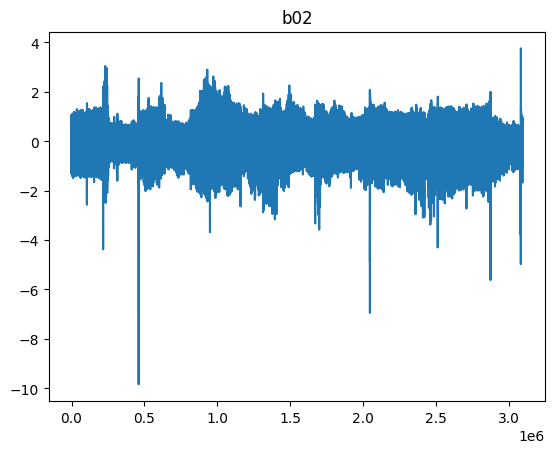

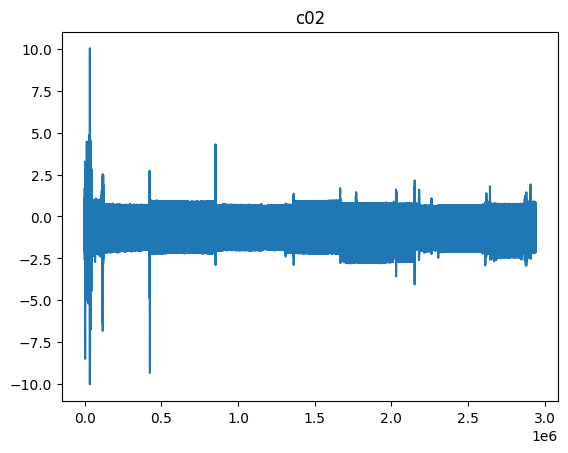

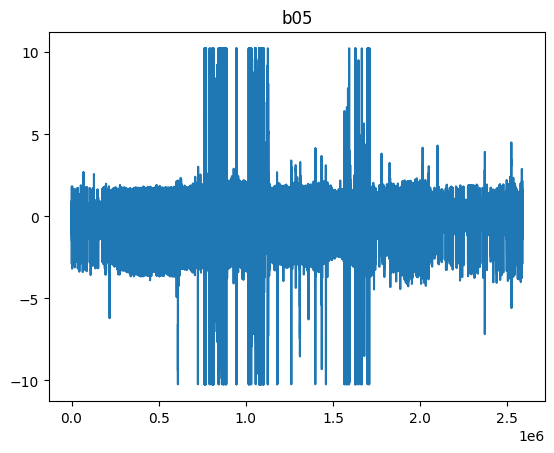

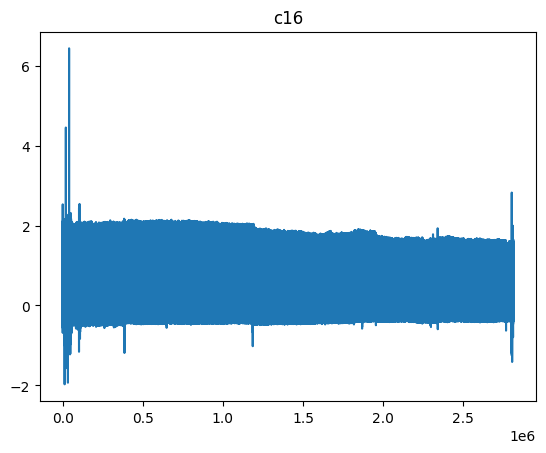

In [11]:
import random
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import islice


def generate_file_list():
    return [
        f"{prefix}{i:02d}"
        for prefix, count in [("a", 40), ("b", 10), ("c", 20)]
        for i in range(1, count + 1)
    ]


def plot_ecg(file, data):
    plt.figure()
    plt.plot(data["ecg"].flatten())
    plt.title(file)
    plt.show()


def main():
    file_full = generate_file_list()
    random.shuffle(file_full)
    data_folder = "./output/processed"

    type_counts = defaultdict(int)
    target_count = 2

    for file in file_full:
        file_type = file[0]

        if type_counts[file_type] >= target_count:
            continue

        with open(f"{data_folder}/{file}.pkl", "rb") as f:
            res = pickle.load(f)

        plot_ecg(file, res)
        type_counts[file_type] += 1

        if all(count >= target_count for count in type_counts.values()):
            break


if __name__ == "__main__":
    main()

# Generate Heart rate data

In [12]:
import pickle
from pathlib import Path

# Load a sample file
input_path = Path("./output/processed/a01.pkl")
with input_path.open("rb") as f:
    data = pickle.load(f)

print(data.keys())  # See if 'ecg' is a key

dict_keys(['ecg', 'apn', 'r_peaks', 'atfs'])


In [14]:
import pickle
import numpy as np
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, as_completed
import logging
from tqdm import tqdm

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)


def generate_file_list():
    return (
        [f"a{i:02d}" for i in range(1, 41)]
        + [f"b{i:02d}" for i in range(1, 11)]
        + [f"c{i:02d}" for i in range(1, 21)]
    )


def process_file(file, input_folder, output_folder):
    try:
        input_path = Path(input_folder) / f"{file}.pkl"
        output_path = Path(output_folder) / f"{file}.pkl"

        logging.info(f"Processing {file} from {input_path} to {output_path}")

        if not input_path.exists():
            raise FileNotFoundError(f"Input file {input_path} does not exist")

        with input_path.open("rb") as f:
            data = pickle.load(f)

        t_hr, hr = [], []
        for minute, ecg_minute in enumerate(data["ecg"]):
            t_hr_, hr_ = extract_heart_rate(ecg_minute)
            t_hr_ = t_hr_ / 60 + minute  # Unit in minutes
            t_hr.extend(t_hr_)
            hr.extend(hr_)

        res = {"hr": np.array(hr), "t": np.array(t_hr), "apn": data["apn"]}

        # Ensure the directory exists before saving
        output_path.parent.mkdir(parents=True, exist_ok=True)
        logging.info(f"Created folder {output_path.parent}")

        with output_path.open("wb") as f:
            pickle.dump(res, f)
            logging.info(f"Successfully saved {output_path}")

        return f"Processed {file} successfully"
    except Exception as e:
        logging.error(f"Error processing {file}: {str(e)}")
        return f"Error processing {file}: {str(e)}"


def main():
    input_folder = "./output/processed"
    output_folder = "./heartRate/"
    file_list = generate_file_list()

    with ProcessPoolExecutor() as executor:
        futures = [
            executor.submit(process_file, file, input_folder, output_folder)
            for file in file_list
        ]

        for future in tqdm(
            as_completed(futures), total=len(file_list), desc="Processing files"
        ):
            result = future.result()
            logging.info(result)


if __name__ == "__main__":
    main()

Processing files:   0%|          | 0/70 [00:00<?, ?it/s]INFO:root:Processing a02 from output/processed/a02.pkl to heartRate/a02.pkl
INFO:root:Processing a03 from output/processed/a03.pkl to heartRate/a03.pkl
INFO:root:Processing a01 from output/processed/a01.pkl to heartRate/a01.pkl
INFO:root:Processing a04 from output/processed/a04.pkl to heartRate/a04.pkl
INFO:root:Processing a05 from output/processed/a05.pkl to heartRate/a05.pkl
INFO:root:Processing a06 from output/processed/a06.pkl to heartRate/a06.pkl
INFO:root:Processing a08 from output/processed/a08.pkl to heartRate/a08.pkl
INFO:root:Processing a07 from output/processed/a07.pkl to heartRate/a07.pkl
INFO:root:Created folder heartRate
INFO:root:Successfully saved heartRate/a07.pkl
INFO:root:Processing a09 from output/processed/a09.pkl to heartRate/a09.pkl
INFO:root:Processed a07 successfully
Processing files:   1%|▏         | 1/70 [00:13<15:22, 13.36s/it]INFO:root:Created folder heartRate
INFO:root:Successfully saved heartRate/a05

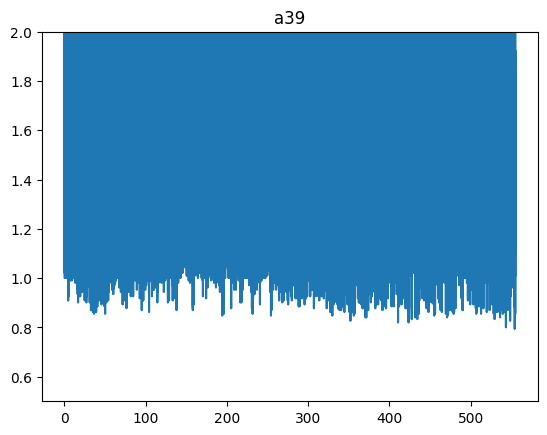

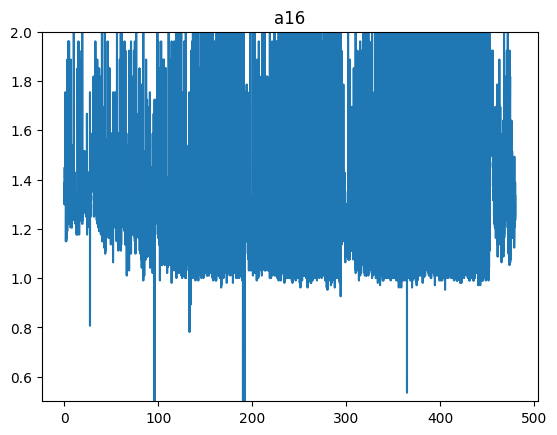

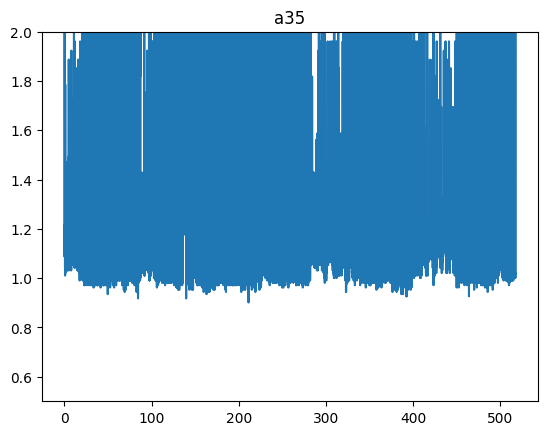

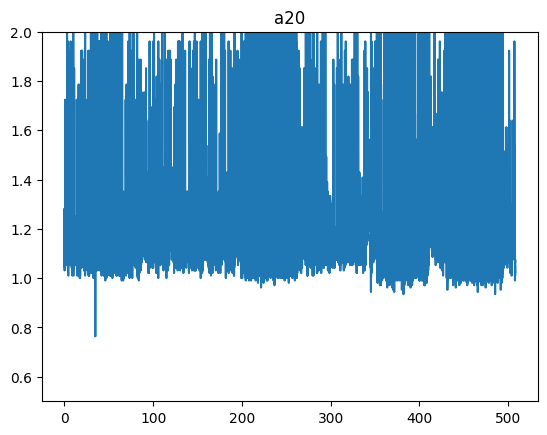

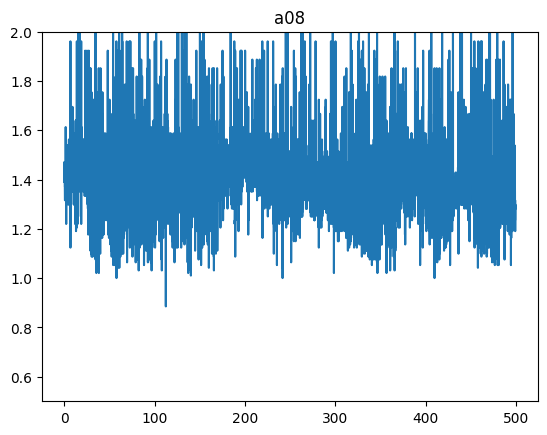

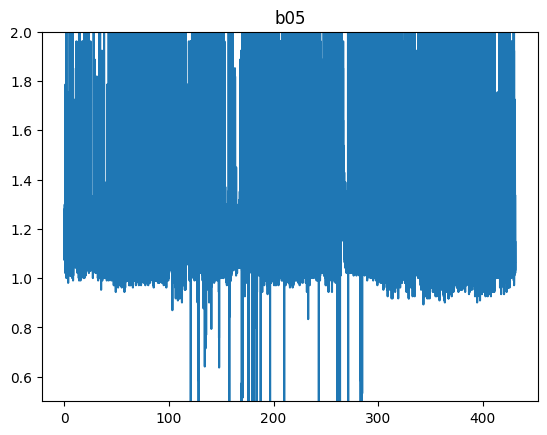

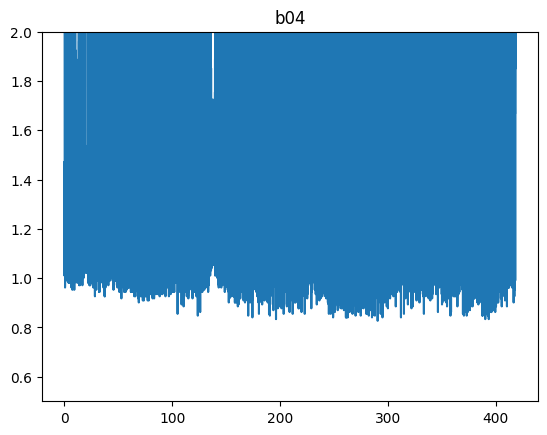

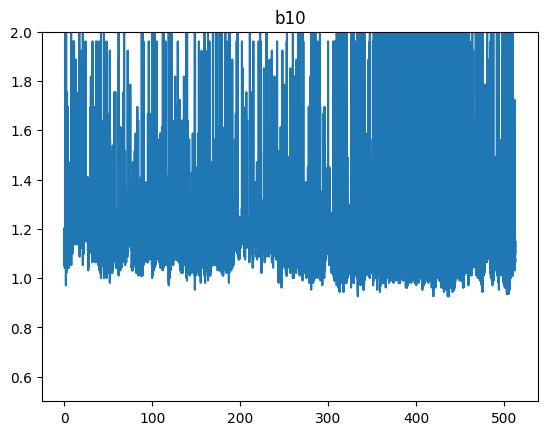

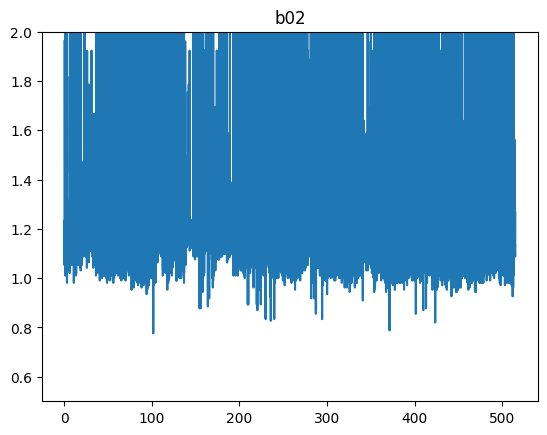

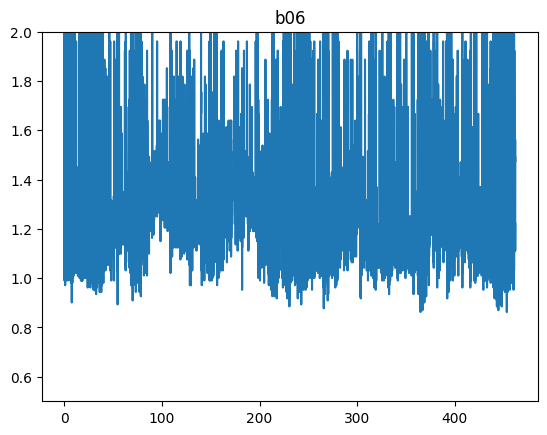

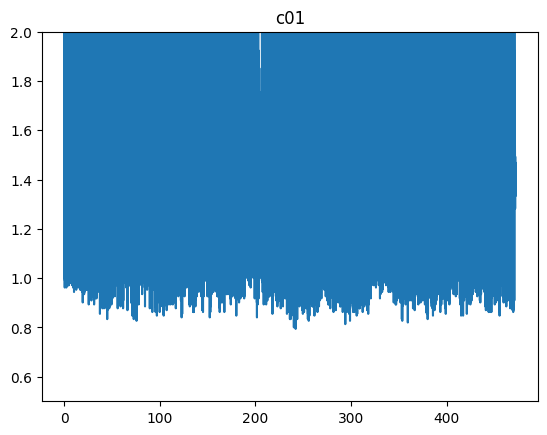

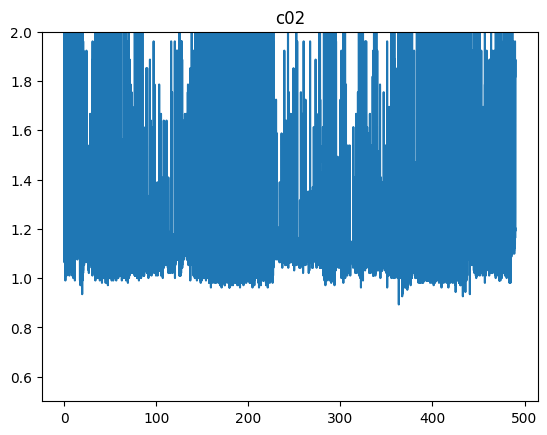

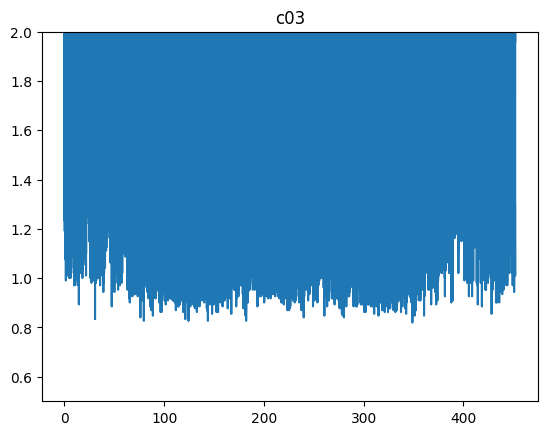

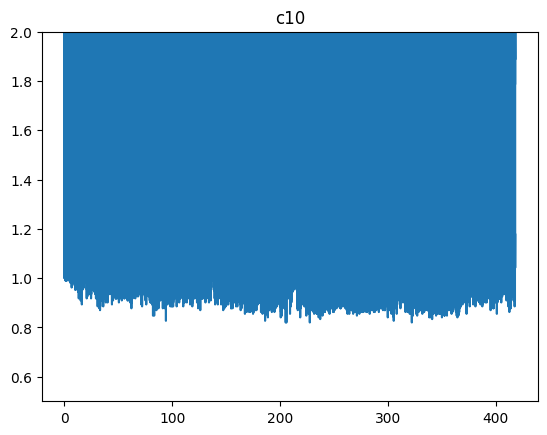

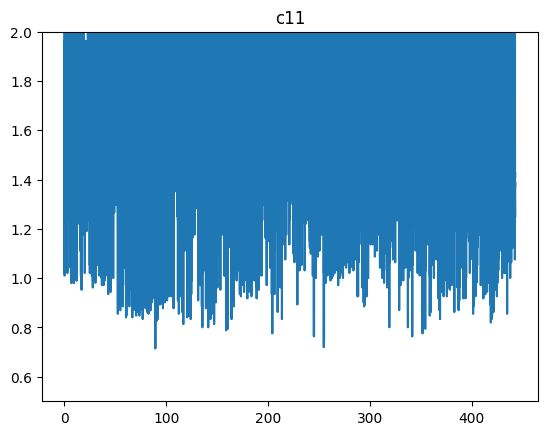

In [15]:
import os
import pickle
import matplotlib.pyplot as plt
import random

file_full = (
    [f"a{i:02d}" for i in range(1, 41)]
    + [f"b{i:02d}" for i in range(1, 11)]
    + [f"c{i:02d}" for i in range(1, 21)]
)

# Select 5 random files from each range
file_samples = (
    random.sample([f"a{i:02d}" for i in range(1, 41)], 5)
    + random.sample([f"b{i:02d}" for i in range(1, 11)], 5)
    + random.sample([f"c{i:02d}" for i in range(1, 21)], 5)
)

for file in file_samples:
    with open(f"./heartRate/{file}.pkl", "rb") as f:
        res = pickle.load(f)

    plt.figure()
    plt.plot(res["t"], res["hr"])
    plt.ylim([0.5, 2])
    plt.title(file)
    plt.show()

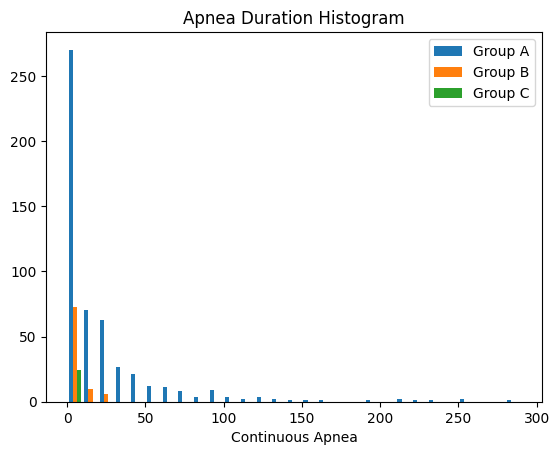

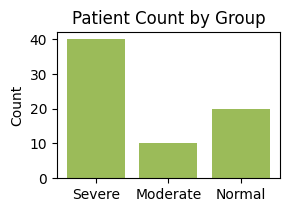

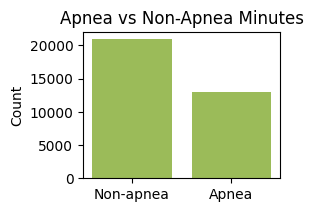

1.6085955487336914


In [16]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import re


def load_file(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(f)


def process_file(file, file_path, apn_duration, pos_num, neg_num, patient_num):
    if not os.path.exists(file_path):
        return pos_num, neg_num

    res = load_file(file_path)
    apn = res["apn"]
    group = file[0].upper()

    # Continuous apnea duration
    apn = np.array2string(apn.astype(int))  # Convert label to string 00011...
    apn = "".join(re.split(" |\n", apn))  # Remove space and line break
    apn_duration[group].append(
        list(map(len, re.findall(r"1+", apn)))
    )  # Length of continuous 1

    # Number of apnea and non-apnea minutes
    pos_num += len(re.findall(r"1", apn))
    neg_num += len(re.findall(r"0", apn))

    # Number of each diagnosis group
    patient_num[group] += 1

    return pos_num, neg_num


def create_histogram(data, bins, labels, xlabel, title):
    plt.hist(data, bins)
    plt.legend(labels)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()


def create_bar_chart(data, labels, ylabel, title):
    fig = plt.figure(figsize=(3, 2))
    plt.bar(range(len(data)), data, color=np.array([155, 187, 89]) / 255)
    plt.xticks(range(len(data)), labels=labels)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.title(title)
    plt.show()


def main():
    file_full = (
        [f"a{i:02d}" for i in range(1, 41)]
        + [f"b{i:02d}" for i in range(1, 11)]
        + [f"c{i:02d}" for i in range(1, 21)]
    )

    duration = []
    pos_num, neg_num = 0, 0
    patient_num = {"A": 0, "B": 0, "C": 0}
    apn_duration = {"A": [], "B": [], "C": []}

    for file in file_full:
        file_path = f"output/processed/{file}.pkl"
        pos_num, neg_num = process_file(
            file, file_path, apn_duration, pos_num, neg_num, patient_num
        )

    duration_A = np.hstack(apn_duration["A"])
    duration_B = np.hstack(apn_duration["B"])
    duration_C = np.hstack(apn_duration["C"])

    create_histogram(
        [duration_A, duration_B, duration_C],
        np.arange(0, 300, 10),
        ["Group A", "Group B", "Group C"],
        "Continuous Apnea",
        "Apnea Duration Histogram",
    )

    create_bar_chart(
        list(patient_num.values()),
        ["Severe", "Moderate", "Normal"],
        "Count",
        "Patient Count by Group",
    )

    create_bar_chart(
        [neg_num, pos_num],
        ["Non-apnea", "Apnea"],
        "Count",
        "Apnea vs Non-Apnea Minutes",
    )

    print(neg_num / pos_num)


if __name__ == "__main__":
    main()

# Train test split based on group

In [17]:
import os
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split

file_full = (
    [f"a{i:02d}" for i in range(1, 41)]
    + [f"b{i:02d}" for i in range(1, 11)]
    + [f"c{i:02d}" for i in range(1, 21)]
)

rows = []

for file in file_full:
    file_path = f"./heartRate/{file}.pkl"  # Corrected path
    if not os.path.exists(file_path):
        continue

    with open(file_path, "rb") as f:
        data = pickle.load(f)

    group = file[0].upper()  # Correct grouping
    row = {
        "file": file,
        "pos": sum(data["apn"]),
        "neg": sum(1 - data["apn"]),
        "group": group,  # Ensuring the group column exists
    }
    rows.append(row)

df = pd.DataFrame(rows)

# Check if 'group' column exists and if the DataFrame is populated correctly
print(df.columns)
print(df.head())

# Proceed with splitting the data
df_train, df_test = train_test_split(
    df, test_size=0.2, stratify=df["group"], random_state=1
)

Index(['file', 'pos', 'neg', 'group'], dtype='object')
  file  pos  neg group
0  a01  469   18     A
1  a02  419  107     A
2  a03  245  272     A
3  a04  452   38     A
4  a05  276  176     A


1.4780904880655503


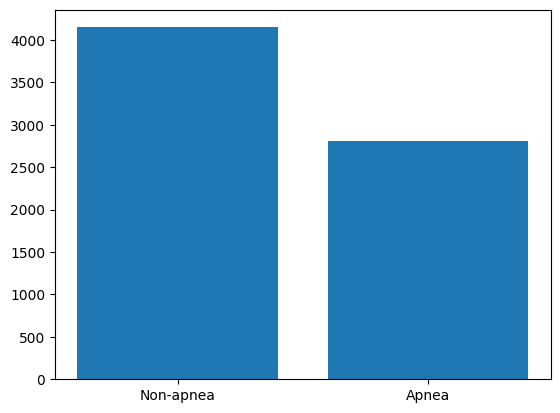

In [18]:
plt.bar(x=["Non-apnea", "Apnea"], height=[df_test["neg"].sum(), df_test["pos"].sum()])
print(df_test["neg"].sum() / df_test["pos"].sum())

In [19]:
df

,file,pos,neg,group
0,a01,469,18,A
1,a02,419,107,A
2,a03,245,272,A
3,a04,452,38,A
4,a05,276,176,A
...,...,...,...,...
65,c16,2,467,C
66,c17,0,450,C
67,c18,3,468,C
68,c19,0,470,C


In [20]:
df.to_csv('./File_all.csv', index=False)
df_test.to_csv('./File_test.csv', index=False)
df_train.to_csv('./File_train.csv', index=False)

# Wavelet spectogram

In [1]:
def extract_cwt_all(file_names):
    df = pd.DataFrame()
    for file in file_names:
        cwt, apn, group = extract_cwt(
            file,
            fs_new=1,
            smooth=True,
            cwt_width=128,
            return_segments=True,
            segment_window=3,
        )
        df_temp = pd.DataFrame(
            {
                "cwt": cwt,
                "apn": apn,
                "group": [group] * len(apn),
                "file": [file] * len(apn),
            }
        )
        df = pd.concat([df, df_temp], axis=0, ignore_index=True)

    df["apn"] = df["apn"].astype(int)
    return df

/tmp/ipykernel_39264/4081189084.py:278: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwt = signal.cwt(hr, signal.ricker, widths)


-6.444656809591768 12.293236802506458


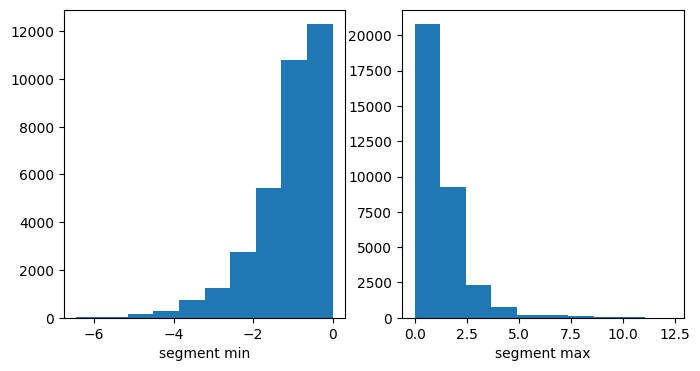

In [5]:
import os
import pickle
import pandas as pd

# Ensure that the directory exists
output_dir = 'output/CWT/'
os.makedirs(output_dir, exist_ok=True)

file_df = pd.read_csv('./File_all.csv')
df = extract_cwt_all(file_df['file'])

# Now save the file after ensuring the directory exists
with open(os.path.join(output_dir, 'cwt_all.pkl'), 'wb') as f:
    pickle.dump(df, f)


df['min'] = df['cwt'].apply(np.min)
df['max'] = df['cwt'].apply(np.max)

print(np.min(df['min']), np.max(df['max']))

fig = plt.figure(figsize=(8, 4))
fig.add_subplot(1, 2, 1)
plt.hist(df['min'])
plt.xlabel('segment min')
fig.add_subplot(1, 2, 2)
plt.hist(df['max'])
plt.xlabel('segment max')
plt.show()

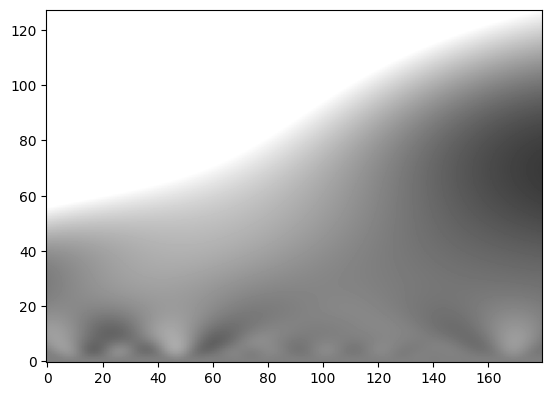

In [6]:
with open("output/CWT/cwt_all.pkl", "rb") as f:
    df = pickle.load(f)

# Sample image
plt.imshow(
    df['cwt'][0], cmap='gray', aspect='equal', origin='lower',
    vmin=-2, vmax=2,
)

In [7]:
file_df = pd.read_csv("./File_all.csv")
data_folder = "./Apnea_data"
os.makedirs(data_folder, exist_ok=True)

for file in file_df["file"]:
    if not os.path.isdir(f"{data_folder}/{file}"):
        os.mkdir(f"{data_folder}/{file}")

    # Generate folders
    for subfolder in ["0", "1"]:
        if not os.path.isdir(f"{data_folder}/{file}/{subfolder}"):
            os.mkdir(f"{data_folder}/{file}/{subfolder}")

    # Extract df
    df_temp = df[df["file"] == file]

    # Generate images
    for index, row in df_temp.iterrows():
        subfolder = "1" if row["apn"] else "0"
        plt.imsave(
            f"{data_folder}/{file}/{subfolder}/{index}.png",
            row["cwt"],
            cmap="gray",
            origin="lower",
            vmin=-2,
            vmax=2,
        )

In [8]:
import os
import shutil

# Define paths
original_dataset_path = "Apnea_data"
new_dataset_path = "Binary_Classification_Apnea"
non_apnea_dir = os.path.join(new_dataset_path, "non_apnea")
apnea_dir = os.path.join(new_dataset_path, "apnea")

# Create new directories if they don't exist
os.makedirs(non_apnea_dir, exist_ok=True)
os.makedirs(apnea_dir, exist_ok=True)

# List of patient directories
file_full = (
    [f"a{i:02d}" for i in range(1, 41)]
    + [f"b{i:02d}" for i in range(1, 11)]
    + [f"c{i:02d}" for i in range(1, 21)]
)


# Function to move images to new dataset
def segregate_images(patient_dir):
    patient_path = os.path.join(original_dataset_path, patient_dir)

    for class_label in ["0", "1"]:
        class_path = os.path.join(patient_path, class_label)
        if os.path.exists(class_path):
            for image in os.listdir(class_path):
                image_path = os.path.join(class_path, image)
                if class_label == "0":
                    dest_path = os.path.join(non_apnea_dir, image)
                else:
                    dest_path = os.path.join(apnea_dir, image)
                shutil.copy(image_path, dest_path)


# Process each patient directory
for patient in file_full:
    segregate_images(patient)

print("Images have been segregated successfully!")

Images have been segregated successfully!


In [34]:
!zip -r Binary_Classification_Apnea.zip ./Binary_Classification_Apnea

Streaming output truncated to the last 5000 lines.
  adding: Binary_Classification_Apnea/non_apnea/31535.png (stored 0%)
  adding: Binary_Classification_Apnea/non_apnea/23569.png (stored 0%)
  adding: Binary_Classification_Apnea/non_apnea/6385.png (stored 0%)
  adding: Binary_Classification_Apnea/non_apnea/5627.png (deflated 0%)
  adding: Binary_Classification_Apnea/non_apnea/4878.png (stored 0%)
  adding: Binary_Classification_Apnea/non_apnea/9426.png (stored 0%)
  adding: Binary_Classification_Apnea/non_apnea/24482.png (stored 0%)
  adding: Binary_Classification_Apnea/non_apnea/11909.png (stored 0%)
  adding: Binary_Classification_Apnea/non_apnea/22901.png (stored 0%)
  adding: Binary_Classification_Apnea/non_apnea/28708.png (stored 0%)
  adding: Binary_Classification_Apnea/non_apnea/26566.png (stored 0%)
  adding: Binary_Classification_Apnea/non_apnea/8421.png (stored 0%)
  adding: Binary_Classification_Apnea/non_apnea/25959.png (stored 0%)
  adding: Binary_Classification_Apnea/non_